# SINVAD Experiments - Research Question 3 (Problem Detection)

This notebook provides outlines on experiments performed for RQ3 (Section 5.4 of the paper). It contains code that generates results similar to those presented in Figure 14-15 of the paper.

Note that the code here may take a long time to execute.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

from sa.model import MnistClassifier
from vae.model import VAE

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm_n
torch.no_grad()

In [2]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load('./vae/models/MNIST_EnD.pth'))
vae.cuda()

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready...")

Data loader ready...


## Step 1. Calculating SINVAD success matrix.

Figure 14(b) of paper is calculated.

In [3]:
# various hyperparameters
img_size = 28*28*1
gen_num = 100
pop_size = 50
best_left = 20
mut_size = 0.1
imgs_to_samp = 1000

In [4]:
classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load(f'./stunted_dataset/models/MNIST_stunt_0.000.pth'))
classifier.eval()
classifier.cuda()
print('load ok')

load ok


In [5]:
fail_matrix = np.zeros((10, 10))
for src_idx in range(0, 10):
    for dst_idx in range(0, 10):
        ### Sample image ###
        for img_idx in range(imgs_to_samp):
            for i, (x, x_class) in enumerate(test_data_loader):
                samp_img = x[0:1]
                samp_class = x_class[0].item()
                if samp_class == src_idx: break

            img_enc, _ = vae.encode(samp_img.view(-1, img_size).cuda())

            ### Initialize optimization ###
            init_pop = [img_enc + 1.0 * torch.randn(1, 400).cuda() for _ in range(pop_size)]
            now_pop = init_pop
            prev_best = 999
            binom_sampler = torch.distributions.binomial.Binomial(probs=0.5*torch.ones(img_enc.size()))

            ### GA ###
            for g_idx in range(gen_num):
                indivs = torch.cat(now_pop, dim=0)
                dec_imgs = vae.decode(indivs).view(-1, 1, 28, 28)
                all_logits = classifier(dec_imgs)

                fail_dst = [dst_idx != torch.argmax(all_logits[i_idx]) for i_idx in range(pop_size)]

                indv_score = [999 if not_dst else torch.sum(torch.abs(indivs[i_idx] - img_enc))
                              for i_idx, not_dst in zip(range(pop_size), fail_dst)]

                best_idxs = sorted(range(len(indv_score)), key=lambda i: indv_score[i], reverse=True)[-best_left:]
                now_best = min(indv_score)

                # adaptive mutation strength
                if now_best == prev_best:
                    mut_size *= 0.7
                elif np.all(fail_dst):
                    mut_size *= 1.2
                else:
                    mut_size = 0.1

                parent_pop = [now_pop[idx] for idx in best_idxs]

                k_pop = []
                for k_idx in range(pop_size-best_left):
                    # crossover
                    mom_idx, pop_idx = np.random.choice(best_left, size=2, replace=False)
                    spl_idx = np.random.choice(400, size=1)[0]
                    k_gene = torch.cat([parent_pop[mom_idx][:, :spl_idx], parent_pop[pop_idx][:, spl_idx:]], dim=1)
                    # mutation
                    diffs = (k_gene != img_enc).float()
                    k_gene += mut_size * torch.randn(k_gene.size()).cuda() * diffs # random adding noise only to diff places
                    # random matching to img_enc
                    interp_mask = binom_sampler.sample().cuda()
                    k_gene = interp_mask * img_enc + (1 - interp_mask) * k_gene

                    k_pop.append(k_gene)
                now_pop = parent_pop + k_pop
                prev_best = now_best
                
                if mut_size < 1e-3:
                    break # that's enough

            ### Logging ###
            mod_best = parent_pop[-1].clone()
            final_bound_img = vae.decode(parent_pop[-1])
            final_bound_img = final_bound_img.detach().cpu().numpy()
            if now_best == 999:
                final_bound_img = 1. - final_bound_img
                fail_matrix[src_idx][dst_idx] += 1
            print('\r' + ' '*100 + '\r', end='')
            print(f'{src_idx}->{dst_idx}:{img_idx+1}/{imgs_to_samp} done', end='')

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


9->9:1000/1000 done                                                                                 

In [6]:
np.save('MNIST_fail_matrix.npy', fail_matrix)

In [7]:
sh = imgs_to_samp-fail_matrix

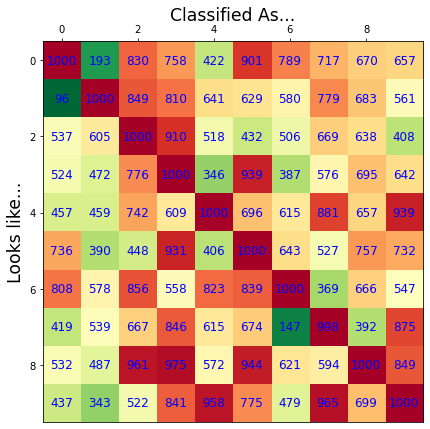

In [8]:
fig, ax = plt.subplots()
ax.imshow(-sh, cmap='RdYlGn', interpolation='nearest')
for x in range(10):
    for y in range(10):
        ax.text(x, y, str(int(sh[y][x])), 
                 horizontalalignment='center', verticalalignment='center',
                 color='blue', fontsize='large')
        
ax.set_xlabel('Classified As...', fontsize='xx-large')
ax.set_ylabel('Looks like...', fontsize='xx-large')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
        
plt.show()

## Figure 15 with precomputed data

In [13]:
from pickle import load
pairs = [(0, 1), (2, 5), (6, 7)]
graph_data = []
for sc1, sc2 in pairs:
    with open(f'./data/precomputed/{sc1}{sc2}rq4res.pkl', 'rb') as f:
        graph_data.append(load(f))

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <a list of 8 Text yticklabel objects>)

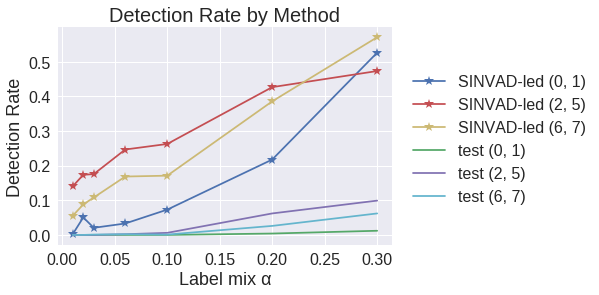

In [14]:
x_coords = [1e-2, 2e-2, 3e-2, 6e-2, 1e-1, 2e-1, 3e-1, 5e-1]
imgs_to_samp = 1000
fig, ax = plt.subplots()
for pair, (tyl, syl) in zip(pairs, graph_data):
    tyc = np.array(tyl)
    syc = np.array(syl[1:-1])-syl[0]
    ax.plot(x_coords[:syc.shape[0]], syc/2/imgs_to_samp, label=f'SINVAD-led {pair}', marker='*', markersize=10)
    ax.plot(x_coords[:syc.shape[0]], tyc[:syc.shape[0]]/1000, label=f'test {pair}', marker='x', markersize=10)
    
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, bbox_to_anchor=(1.02, 0.85), fontsize=16)
plt.title('Detection Rate by Method', fontsize=20)
plt.ylabel('Detection Rate', fontsize=18)
plt.xlabel('Label mix α', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [16]:
with open('./data/precomputed/imagenet_result_data.pkl', 'rb') as f:
    PAIRS, GRAPH_DATA = load(f)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 9 Text yticklabel objects>)

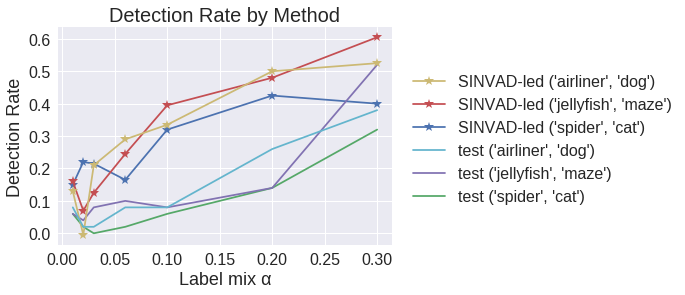

In [17]:
x_coords = [1e-2, 2e-2, 3e-2, 6e-2, 1e-1, 2e-1, 3e-1, 5e-1]
fig, ax = plt.subplots()
for pair, (tyl, syl) in zip(PAIRS, GRAPH_DATA):
    tyc = np.array(tyl)
    syc = np.array(syl[1:])-syl[0]
    ax.plot(x_coords[:syc.shape[0]], syc/200, label=f'SINVAD-led {pair}', marker='*', markersize=10)
    ax.plot(x_coords[:syc.shape[0]], tyc[:syc.shape[0]]/50, label=f'test {pair}', marker='x', markersize=10)
    
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
plt.legend(handles, labels, bbox_to_anchor=(1.02, 0.85), fontsize=16)
plt.title('Detection Rate by Method', fontsize=20)
plt.ylabel('Detection Rate', fontsize=18)
plt.xlabel('Label mix α', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Appendix: Raw Code for Generating Figure 15

In [9]:
expr_list = ['0.000', '0.010', '0.020', '0.030', '0.060', '0.100', '0.200', '0.300', '0.500']

In [10]:
# various hyperparameters
img_size = 28*28*1
gen_num = 100
pop_size = 50
best_left = 20
mut_size = 0.1
imgs_to_samp = 100
conf_pair = (0, 1)
# abbreviations
c1, c2 = conf_pair

In [11]:
test_y_list = []
for e_idx, expr in enumerate(expr_list[1:]):
    fail_matrix = np.zeros((2, 2))
    classifier = MnistClassifier(img_size = img_size)
    classifier.load_state_dict(torch.load(f'./stunted_dataset/models/MNIST_stunt_{c1}{c2}_{expr}.pth'))
    classifier.eval()
    classifier.cuda()

    error_matrix = np.zeros((10, 10))
    for tx, tx_class in test_data_loader:
        tx = tx.cuda()
        tclass_logits = classifier(tx)
        _, mostprob_result = torch.max(tclass_logits, dim=1)
        mostprob_result = mostprob_result.cpu()
        for true_class, pred_class in zip(tx_class, mostprob_result):
            error_matrix[true_class.item(), pred_class.item()] += 1
    test_y_list.append(error_matrix[0, 1] + error_matrix[1, 0])

In [12]:
# SINVAD success rate over multiple variables
succ_y_list = []
for e_idx, expr in enumerate(expr_list):
    fail_matrix = np.zeros((2, 2))
    classifier = MnistClassifier(img_size = img_size)
    classifier.load_state_dict(torch.load(f'./stunted_dataset/models/MNIST_stunt_{c1}{c2}_{expr}.pth'))
    classifier.eval()
    classifier.cuda()
    for src_idx, dst_idx in [(0, 1), (1, 0)]:
        mod_str = f'{src_idx}>{dst_idx}'
        ### Sample image ###
        for img_idx in range(imgs_to_samp):
            for i, (x, x_class) in enumerate(test_data_loader):
                samp_img = x[0:1]
                samp_class = x_class[0].item()
                if samp_class == src_idx: break

            img_enc, _ = vae.encode(samp_img.view(-1, img_size).cuda())

            ### Initialize optimization ###
            init_pop = [img_enc + 1.0 * torch.randn(1, 400).cuda() for _ in range(pop_size)]
            now_pop = init_pop
            prev_best = 999
            binom_sampler = torch.distributions.binomial.Binomial(probs=0.5*torch.ones(img_enc.size()))

            ### GA ###
            for g_idx in range(gen_num):
                indivs = torch.cat(now_pop, dim=0)
                dec_imgs = vae.decode(indivs).view(-1, 1, 28, 28)
                all_logits = classifier(dec_imgs)

                fail_dst = [dst_idx != torch.argmax(all_logits[i_idx]) for i_idx in range(pop_size)]

                if indivs.size(0) != pop_size:
                    break
                indv_score = [999 if not_dst else torch.sum(torch.abs(indivs[i_idx] - img_enc))
                              for i_idx, not_dst in zip(range(pop_size), fail_dst)]

                best_idxs = sorted(range(len(indv_score)), key=lambda i: indv_score[i], reverse=True)[-best_left:]
                now_best = min(indv_score)

                if now_best == prev_best:
                    mut_size *= 0.7
                elif np.all(fail_dst):
                    mut_size *= 1.2
                else:
                    mut_size = 0.1

                parent_pop = [now_pop[idx] for idx in best_idxs]

                k_pop = []
                for k_idx in range(pop_size-best_left):
                    # crossover
                    mom_idx, pop_idx = np.random.choice(best_left, size=2, replace=False)
                    spl_idx = np.random.choice(400, size=1)[0]
                    k_gene = torch.cat([parent_pop[mom_idx][:, :spl_idx], parent_pop[pop_idx][:, spl_idx:]], dim=1)

                    # mutation
                    diffs = (k_gene != img_enc).float()
                    k_gene += mut_size * torch.randn(k_gene.size()).cuda() * diffs # random adding noise only to diff places
                    # random matching to img_enc
                    interp_mask = binom_sampler.sample().cuda()
                    k_gene = interp_mask * img_enc + (1 - interp_mask) * k_gene

                    k_pop.append(k_gene)
                now_pop = parent_pop + k_pop
                prev_best = now_best
                if mut_size < 1e-3:
                    break # that's enough

            mod_best = parent_pop[-1].clone()
            final_bound_img = vae.decode(parent_pop[-1])
            final_bound_img = final_bound_img.detach().cpu().numpy()
            if now_best == 999:
                final_bound_img = 1. - final_bound_img
                fail_matrix[src_idx][dst_idx] += 1
            
            print('\r' + ' '*100 + '\r', end='')
            print(f'Model {expr} | {src_idx}->{dst_idx}:{img_idx+1}/{imgs_to_samp} done', end='')
        
    succ_y_list.append(2*imgs_to_samp-np.sum(fail_matrix))

Model 0.500 | 1->0:100/100 done                                                                     

In [13]:
x_coords = [1e-2, 2e-2, 3e-2, 6e-2, 1e-1, 2e-1, 3e-1, 5e-1]
test_y_coords = np.array(test_y_list)
base_succ = succ_y_list[0]
succ_y_coords = np.array(succ_y_list[1:])-base_succ

Text(0, 0.5, 'Rate')

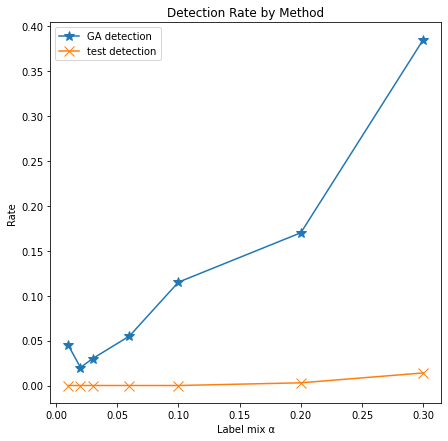

In [14]:
plt.plot(x_coords[:7], succ_y_coords[:7]/2/imgs_to_samp, label='GA detection', marker='*', markersize=10)
plt.plot(x_coords[:7], test_y_coords[:7]/1000, label='test detection', marker='x', markersize=10)
plt.legend(loc='upper left')
plt.title('Detection Rate by Method')
plt.xlabel('Label mix α')
plt.ylabel('Rate')